# This notebook reads text data from data extract created from FSHA Forms and runs predictive Models to predict the value 'Is there a potential for microbial growth in the product?' , based on the Input Data

In [1]:
#import all necessary modules
from __future__ import print_function
import logging
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt
import os
import nltk
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import numpy as np
from numpy import array
from numpy import argmax
from scipy import signal
import random
import string
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn.decomposition import PCA
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
import warnings
warnings.simplefilter('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## File name and other important parameters like ngram_range set

In [2]:
#These parameters will be input from command line
ngram_range_inp=(1,2)
filename = "C:/Pepsico/FSHA RPA - 17 July 2019 Updated_7PM.xlsm"
#n_components = 0

# Define reusable modular method for Text Normalization (removal of stopwords, changing to lower case, removal of punctuation etc) 

In [3]:
exclude = set(string.punctuation) 
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['from','dtype','object']
stop_words.extend(newStopWords)
table = str.maketrans('', '', string.punctuation)

porter = PorterStemmer()

def normalize_document(doc):
    # tokenize document
    tokens = doc.split()
    # remove punctuation from each word
    tokens = [w.translate(table) for w in tokens]
    # convert to lower case
    lower_tokens = [w.lower() for w in tokens]
    #remove spaces
    stripped = [w.strip() for w in lower_tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter stopwords out of document
    filtered_tokens = [token for token in words if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

#normalize_corpus = np.vectorize(normalize_document)

In [4]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    #corpus = str(corpus)
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)

        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        # remove special characters    
        if special_char_removal:
            doc = remove_special_characters(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [5]:
def clean_doc(corpus):
    normalized_corpus = []
    # normalize each document in the corpus
    #corpus = str(corpus)
    for doc in corpus:
	# split into tokens by white space
        doc=str(doc)
        doc = doc.replace('\n',' ')
        tokens = doc.split()
        # prepare regex for char filtering
        re_punc = re.compile('[%s]' % re.escape(string.punctuation))
        # remove punctuation from each word
        tokens = [re_punc.sub('', w) for w in tokens]
        # remove remaining tokens that are not alphabetic
        tokens = [word for word in tokens if word.isalpha()]
        # filter out stop words
        tokens = [w for w in tokens if not w in stop_words]
        # filter out short tokens
        tokens = [word for word in tokens if len(word) > 1]
        # remove nn from each word
        tokens = [re.sub('nn',' ',word) for word in tokens]
        tokens = ' '.join(tokens)
        normalized_corpus.append(tokens)
    return normalized_corpus

# Read the data extract file (tabular format with Input data(X) and target(Y))

In [6]:
fsha_data = pd.read_excel(filename)

In [8]:
fsha_data.head()

,File Name,projName,accolNumber,PDA_projName,projType,projDesc,formulaNumber,owner,sector,center,...,Table1_Row6_Milk,Table1_Row6_Nuts,Table1_Row6_Peanuts,Table1_Row6_Soya,Table1_Row6_Celery,Table1_Row6_Lupin,Table1_Row6_Molluscs,Table1_Row6_Mustard,Table1_Row6_Sesame Seeds,Table1_Row6_Sulphites
0,#46565 FSHA 5.4.1Star Project G3 v2 + FS input...,S-T3-Star-• POL Star Puff (Chrupki) quality –POL,46565,1SKU Star Puffs Onion\n2 SKU Star Puffs Cheese...,Brand Refresh,Star Puffs Cheese & STar Hyper Cheese\nSeasoni...,NaN,Weronika Baranowska,ESSA,Warsaw,...,0,0,1,1,1,0,0,1,0,0
1,#53697 FSHA HT Baguette 4 Cheese UA 2.07.19.xlsm,HT Baguette Four Cheese Flavor,53697,Hrusteam Baguette,Refresh,Launch new seasoning 4 Cheese NL-502-352-9 on ...,NaN,Anna Nikonova,ESSA,Moscow,...,0,0,0,0,0,0,0,1,0,0
2,#57686 FSHA 5.4.1 Red Caviar Azov.xlsm,Lay's Caviar IO 2019 RUS Asov,57686,Lay's Red Caviar,Refresh,Idea is to launch I&O flavour under New Year p...,Not provided,Evgeniy Shklovskiy +79163257848,ESSA,Moscow,...,0,0,0,1,0,0,0,0,0,0
3,#57686 FSHA 5.4.1 Red Caviar Kashira.xlsm,Lay's Caviar IO 2019 RUS Kashira,57686,Lay's Red Caviar,Refresh,Idea is to launch I&O flavour under New Year p...,Not provided,Evgeniy Shklovskiy +79163257848,ESSA,Moscow,...,0,0,0,1,0,0,0,0,0,0
4,Cerezza Kokteyl FSHA 5.4.1-Paprika TR (3) Suad...,Seasoning Harmonization Paprika CU64 Suadiye,45777,Cerezza Kokteyl extruded product,Llift and shift,CQ93 Product is a combination of 2 Extruded an...,None,Basak Ozdere,ESSA,Istanbul,...,0,0,0,1,0,0,0,0,0,1


# Based on Analysis select the Features (X)

In [9]:
#selecting set of columns as Features
features_df=fsha_data[['preservatives', 'pH', 'waterActivity', 'packaging','otherFSA',
            'prodStorageDist', 'foodSafetyProdClaims','targetMarket','allergens','newIngredient','allergensLabeledIMAF']]

# Replace missing values in features with NA

In [10]:
features_df.fillna('NA', inplace=True)

In [11]:
train_df = features_df

# Define reusable code to Vectorize Text column (ex: Allergens) using TF-IDF Vectorizer, after doing Text data normalization

In [12]:
# Vectorization of text data using TF-IDF Vectorizer

# Range (inclusive) of n-gram sizes for tokenizing text.
#NGRAM_RANGE 

# Limit on the number of features. We use the top 20K features.
#TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500


def ngram_vectorize(train_texts, train_labels,ngram_range):
    """Vectorizes texts as ngram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': ngram_range,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Select top 'k' of the vectorized features.
    #selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    #selector.fit(x_train, train_labels)
    #x_train = selector.transform(x_train)

    x_train = x_train.astype('float32')
    return x_train

# Define method to concatenate normalized Text data

In [54]:
train_df.columns

Index(['preservatives', 'pH', 'waterActivity', 'packaging', 'otherFSA',
       'prodStorageDist', 'foodSafetyProdClaims', 'targetMarket', 'allergens',
       'newIngredient', 'allergensLabeledIMAF'],
      dtype='object')

In [13]:
#[['preservatives', 'pH', 'waterActivity', 'packaging','otherFSA',
#            'prodStorageDist', 'foodSafetyProdClaims','targetMarket','allergens','newIngredient']]

train_df['norm_preservatives'] = normalize_corpus(train_df['preservatives'])
train_df['norm_pH'] = normalize_corpus(train_df['pH'])
train_df['norm_waterActivity'] = clean_doc(train_df['waterActivity'])
train_df['norm_packaging'] = normalize_corpus(train_df['packaging'])
train_df['norm_otherFSA'] = normalize_corpus(train_df['otherFSA'])
train_df['norm_prodStorageDist'] = normalize_corpus(train_df['prodStorageDist'])
train_df['norm_foodSafety_prodClaims'] = normalize_corpus(train_df['foodSafetyProdClaims'])
train_df['norm_targetMarket'] = normalize_corpus(train_df['targetMarket'])
train_df['norm_newIngredient'] = normalize_corpus(train_df['newIngredient'])
train_df['norm_allergens'] = normalize_corpus(train_df['allergens'])
train_df['norm_allergens_M']=normalize_corpus(train_df['allergensLabeledIMAF'])

In [14]:
train_df = train_df.drop(['allergens',
 'newIngredient',
 'pH',
 'prodStorageDist',
 'waterActivity',
 'packaging',
 'preservatives',
 'otherFSA',
 'foodSafetyProdClaims',
 'targetMarket','allergensLabeledIMAF'],axis = 1)

In [57]:
train_df.columns

Index(['norm_preservatives', 'norm_pH', 'norm_waterActivity', 'norm_packaging',
       'norm_otherFSA', 'norm_prodStorageDist', 'norm_foodSafety_prodClaims',
       'norm_targetMarket', 'norm_newIngredient', 'norm_allergens',
       'norm_allergens_M'],
      dtype='object')

In [16]:
print(train_df['norm_newIngredient'][:5])
print(train_df['norm_allergens'][:5])

0    yes
1    yes
2     no
3     no
4    yes
Name: norm_newIngredient, dtype: object
0    allergens seasonings cq69 vegetable blend mcco...
1    no new allergen line seasonings 4 cheese conta...
2    inherent milk lactose wheat gluten fish compon...
3    inherent inherent milk lactose wheat gluten fi...
4    wheat starch rusk wheat paprika seasoning whey...
Name: norm_allergens, dtype: object


In [17]:
#selecting set of columns for labelling

#ph value label
train_df['pH_label']=train_df['norm_pH'].apply(lambda x:re.findall(r'[0-9]+', str(x)) if bool(re.search(r'\d', str(x))) else str(0))
def ph_process(x):
    if(len(x)>0):
        x = str(x[0])
    else:
        x = str(x)
    return x
train_df['pH_label']=train_df['pH_label'].apply(lambda x:ph_process(x))    

#'prod_storageDist'column label
def prod_storageDist(x):
    x=str(x.lower())
    if x.__contains__('sun'):
            return 'Keep away from sun'
    elif x.__contains__('ambient')  :
              return 'ambient'
    elif x.__contains__('rte'):
        return 'RTE'
    else:
        return 'NA'
train_df['prod_storageDist_label']=train_df['norm_prodStorageDist'].apply(lambda x:prod_storageDist(x))                                                              

#water activity
def water_activity(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('low'):
        return 'low'
    elif x.__contains__('max'):
        return 'max'
    elif x==str(np.nan):
        return 'NA'
    elif bool(re.search('none|n/a|na',x)):
        return 'NA'
    else:
        return(x)
train_df['waterActivity_label']=train_df['norm_waterActivity'].apply(lambda x:water_activity(x))                                                              
 
#packaging'
def packaging(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('no') and x.__contains__('nitrogen'):
        return 'no nitrogen'
    elif x.__contains__('not') and x.__contains__('n2'):
        return 'no nitrogen'
    elif x.__contains__('nitrogen') and not x.__contains__('no'):
        return 'nitrogen'
    elif x.__contains__('atmosphere'):
        return 'atmosphere'
    elif x==str(np.nan):
        return 'NA'
    elif bool(re.search('none|n/a|na',x)):
        return 'NA'
    else:
        return(x)
    
train_df['packaging_label']=train_df['norm_packaging'].apply(lambda x: packaging(x))  
  
#'preservatives'
def preservatives(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('sodium'):
        return 'Not used as preservatives'
    elif x.__contains__('not') and x.__contains__('seasoning'):
        return 'No Seasoning'
    elif bool(re.search('topping|seasoning',x)):
        return 'Used in seasoning'
    else:
        return ('NA')
    
train_df['preservatives_label']=train_df['norm_preservatives'].apply(lambda x:preservatives(x))

#' otherFSA'
def otherFSA(x):
    x=str(x)
    x=x.lower()
    if bool(re.search('moisture',x)):
        return 'Moisture'
    else:
        return 'NA'
train_df['otherFSA_label']=train_df['norm_otherFSA'].apply(lambda x:otherFSA(x))


def foodsafety_prodclaims(x):
    x=str(x)
    x=x.lower()
    if bool(re.search('^claim',x)):
        return 'Claims Made'
    elif x.__contains__('no claims'):
        return 'No Claims Made'
    elif x.__contains__('allergen'):
        return 'Allergen'
    elif bool(re.search('none|n/a|na',x)):
        return 'NA'
    else:
        return(x)

train_df['foodSafety_prodClaims_label']=train_df['norm_foodSafety_prodClaims'].apply(lambda x:foodsafety_prodclaims(x))  

#' targetMarket'
def targetMarket(x):
    x=str(x)
    x=x.lower()
    if (x.__contains__('choking') or x.__contains__('choke')) and x.__contains__('children'):
        return 'Choking hazard for children'
    elif x.__contains__('allerg'):
        return 'Allergy'
    elif x.__contains__('no') and x.__contains__('change'):
        return 'no'
    else:
        return(x)
train_df['targetMarket_label']=train_df['norm_targetMarket'].apply(lambda x:targetMarket(x))

train_df=train_df.drop(['norm_preservatives', 'norm_pH', 'norm_waterActivity', 'norm_packaging','norm_otherFSA',
            'norm_prodStorageDist', 'norm_foodSafety_prodClaims','norm_targetMarket'],axis=1)


In [18]:
train_df.head()

,norm_newIngredient,norm_allergens,norm_allergens_M,pH_label,prod_storageDist_label,waterActivity_label,packaging_label,preservatives_label,otherFSA_label,foodSafety_prodClaims_label,targetMarket_label
0,yes,allergens seasonings cq69 vegetable blend mcco...,milk lactose milk lactose,0,Keep away from sun,low,atmosphere,NA,NA,Claims Made,Allergy
1,yes,no new allergen line seasonings 4 cheese conta...,milk lactose sulphites 1ppm gluten 3ppm,0,NA,low,NA,NA,NA,NA,no
2,no,inherent milk lactose wheat gluten fish compon...,milk lactose wheat gluten 3ppm sulphites 1ppm ...,0,NA,low,standard,NA,NA,NA,Allergy
3,no,inherent inherent milk lactose wheat gluten fi...,milk lactose wheat gluten 3ppm sulphites 1ppm ...,0,NA,low,standard,NA,NA,NA,Allergy
4,yes,wheat starch rusk wheat paprika seasoning whey...,wheat gluten milk lactose,0,NA,low,nitrogen,NA,NA,NA,no


# Onehot encoding of categorical encoded data

In [19]:
for i in range(0,train_df.shape[1]):
    if train_df.columns[i] != 'norm_allergens' :
        if train_df.columns[i] != 'norm_allergens_M':
        
            df=pd.get_dummies(train_df[train_df.columns[i]])
            df.columns = [train_df.columns[i]+"_"+k for k in df.columns]
            if i ==0 :
                newdf = df
            else:
                newdf = pd.concat([newdf,df],axis=1)

In [25]:
newdf['packaging_label_standard'].head()

0    0
1    0
2    1
3    1
4    0
Name: packaging_label_standard, dtype: uint8

In [26]:
newdf['norm_allergens']= train_df.norm_allergens
newdf['norm_allergens_M']=train_df.norm_allergens_M

In [68]:
train_df=newdf

In [69]:
train_df.columns

Index(['norm_newIngredient_no', 'norm_newIngredient_yes', 'pH_label_0',
       'prod_storageDist_label_Keep away from sun',
       'prod_storageDist_label_NA', 'prod_storageDist_label_ambient',
       'waterActivity_label_NA', 'waterActivity_label_low',
       'waterActivity_label_not determined',
       'waterActivity_label_not specified pd', 'packaging_label_NA',
       'packaging_label_atmosphere', 'packaging_label_nitrogen',
       'packaging_label_not confirmed pd', 'packaging_label_not provided',
       'packaging_label_not required', 'packaging_label_standard',
       'preservatives_label_NA',
       'preservatives_label_Not used as preservatives',
       'otherFSA_label_Moisture', 'otherFSA_label_NA',
       'foodSafety_prodClaims_label_50 less fat comparing fried potato chips',
       'foodSafety_prodClaims_label_Claims Made',
       'foodSafety_prodClaims_label_NA',
       'foodSafety_prodClaims_label_No Claims Made',
       'foodSafety_prodClaims_label_no',
       'foodSafet

# Imput target with mode value

In [29]:
import statistics 

def impute_target(fsha_data,targetName):
    train_y=[]
    for i in range (len(fsha_data)):
        if str(fsha_data[targetName][i]).strip().lower() =='yes':
            train_y.append(1)
        elif str(fsha_data[targetName][i]).strip().lower() =='no':
            train_y.append(0)
        else:
            train_y.append(-1)
               
    mode_y = statistics.mode(train_y)

    for i in range (len(fsha_data)):
        if train_y[i]==-1:
            train_y[i] = mode_y
            
    return train_y

# Target (Yes/No choice) in PDAF are converted to binary values

In [70]:
train_y_microbial = impute_target(fsha_data,"potentialMicrobial")

In [71]:
train_df['target']=train_y_microbial

In [72]:
train_df['target'].value_counts()

0    56
1     3
Name: target, dtype: int64

In [73]:
train_y = train_df['target']
y = train_y

# Perform n-gram vectorization and PCA on text data and concatenate with categorical one-hot encoded data

In [76]:
def preprocess_text(train_df,y):    
    train_labels = y
    x_ngram_allergens = ngram_vectorize(train_df['norm_allergens'], train_labels,n_gram_range).toarray()
    x_ngram_allergens_m = ngram_vectorize(train_df['norm_allergens_M'], train_labels,n_gram_range).toarray()
    train_df = train_df.drop(['norm_allergens','norm_allergens_M'],axis=1)
    pca = PCA(n_components=n_components,svd_solver=svd_solver,whiten=whiten, random_state=42)
    
    #scaler = StandardScaler()
    #x_ngram_allergens = scaler.fit_transform(x_ngram_allergens)
    x_pca_allergens = pca.fit_transform(x_ngram_allergens)
    x_pca_allergens_m = pca.fit_transform(x_ngram_allergens_m)
    print(x_pca_allergens.shape)
    print(x_pca_allergens_m.shape)
    print(train_df.shape)
    x_train = np.concatenate((train_df,x_pca_allergens,x_pca_allergens_m),axis=1)
    print(x_train.shape)
    return x_train  

In [77]:
n_gram_range = (1,2)
n_components = 2
whiten = False
random_state = 42
svd_solver="full"
x_train = preprocess_text(train_df,y)

(59, 2)
(59, 2)
(59, 35)
(59, 39)


# Perform train test split

In [78]:
X,y = x_train,train_df['target']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [80]:
print(X_train.shape)
print(X_test.shape)

(47, 39)
(12, 39)


In [81]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

# Upsample the potentialMicrobial data, since the data is highly imbalanced

In [82]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_potMicrobial = X[X.target==0]
potMicrobial = X[X.target==1]

In [83]:
print(len(not_potMicrobial))
print(len(potMicrobial))

44
3


In [84]:
# upsample minority
potMicrobial_upsampled = resample(potMicrobial,
                          replace=True, # sample with replacement
                          n_samples=len(not_potMicrobial), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_potMicrobial, potMicrobial_upsampled])

In [85]:
upsampled.target.value_counts()

1.0    44
0.0    44
Name: target, dtype: int64

In [86]:
y_train = upsampled.target
X_train = upsampled.drop('target', axis=1)

In [87]:
X_train.shape

(88, 39)

In [90]:
#np.where(np.isnan(X_train))

In [91]:
y_train=y_train.reshape(y_train.shape[0],1)

In [92]:
X_train= X_train.values
#y_train =y_train.values

# Define method to evaluate Machine Learning models with the X and y vectors created above, and check the effectiveness of each. Also store the results in array to be plotted in graph for visualization

In [93]:
from datetime import datetime
import time
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(len(X_train))
    
    clf_descr = str(clf).split('(')[0]
    print("model name:"+clf_descr)
  
    a = datetime.now()
    
    if clf_descr.__contains__('tensorflow'):
        history = clf.fit(
            X_train,
            y_train,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(X_test, y_test),
            verbose=2, 
            batch_size=batch_size)
    else:
        clf.fit(X_train, y_train)
    
    b = datetime.now()
    c = a-b
    train_time = c.microseconds
    print("train time: %0.3fs" % train_time)

    pred = clf.predict(X_test)

    pred_train = clf.predict(X_train)
 
    if clf_descr.__contains__('tensorflow'):
        for i in range (len(pred)):
            if (pred[i]>=0.3):
                pred[i]=1
            else:
                pred[i]=0
        for i in range (len(pred_train)):        
            if (pred_train[i]>=0.3):
                pred_train[i]=1
            else:
                pred_train[i]=0
    
    f1_score = metrics.f1_score(y_test, pred)
    print("f1_score:   %0.3f" % f1_score )
    
    f1_score_train = metrics.f1_score(y_train, pred_train)
    print("f1_score_train:   %0.3f" % f1_score_train )
    
    print("classification report:")
    print(classification_report(y_test, pred))
    
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    
    return clf_descr,f1_score_train,f1_score,train_time

# Evaluate Machine Learning Models from a List (using the reusable method defined above). Store the results (Accuracy score - train, accuracy score - test, and training time) in a List for data visualization

In [94]:
# Not using MultinomialNaiveBayes, because sampled data has negative components. NaiveBayes expects frequencies in the positive
selector = SelectKBest(f_classif, k='all')
results = []
model_name = []

for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=5), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    selector_clf = benchmark(Pipeline([('selector', selector),('classifier', clf)]))
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))
    model_name.append(name)
    #model.append(clf)
    
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,dual=False, tol=1e-3)))
    model_name.append("LinearSVC"+" "+penalty)

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,penalty=penalty)))
    model_name.append("SGDClassifier"+" "+penalty)


# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,penalty="elasticnet")))
model_name.append("SGD with Elastic Net penalty")


# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))
model_name.append("NearestCentroid (aka Rocchio classifier)")


________________________________________________________________________________
Training: 
88
model name:Pipeline


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Define Neural Network model

In [131]:
def mlp_model(layers, units, dropout_rate, input_shape):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.

    # Returns
        An MLP model instance.
    """
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Compile Model

In [132]:
learning_rate=1e-3
epochs=100
batch_size=128
layers=2
units=64
dropout_rate=0.2
model = mlp_model(layers=layers,units=units,dropout_rate=dropout_rate,input_shape=X_train.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


# Train model and store results in array

In [133]:
print('=' * 80)
print("Keras Dense Neural Network")
results.append(benchmark(model))
model_name.append("Keras Dense Neural Network")

Keras Dense Neural Network
________________________________________________________________________________
Training: 
1600
model name:<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000000022399EB8>
Train on 1600 samples, validate on 400 samples
Epoch 1/100
 - 0s - loss: 0.4915 - acc: 0.7663 - val_loss: 0.2513 - val_acc: 0.9300
Epoch 2/100
 - 0s - loss: 0.2616 - acc: 0.9013 - val_loss: 0.1171 - val_acc: 1.0000
Epoch 3/100
 - 0s - loss: 0.1600 - acc: 0.9588 - val_loss: 0.0636 - val_acc: 1.0000
Epoch 4/100
 - 0s - loss: 0.1216 - acc: 0.9669 - val_loss: 0.0400 - val_acc: 1.0000
Epoch 5/100
 - 0s - loss: 0.0999 - acc: 0.9719 - val_loss: 0.0280 - val_acc: 1.0000
Epoch 6/100
 - 0s - loss: 0.0766 - acc: 0.9831 - val_loss: 0.0208 - val_acc: 1.0000
Epoch 7/100
 - 0s - loss: 0.0673 - acc: 0.9850 - val_loss: 0.0162 - val_acc: 1.0000
Epoch 8/100
 - 0s - loss: 0.0588 - acc: 0.9881 - val_loss: 0.0130 - val_acc: 1.0000
Epoch 9/100
 - 0s - loss: 0.0492 - acc: 0.9912 - val_loss: 0.0

Epoch 91/100
 - 0s - loss: 0.0082 - acc: 0.9981 - val_loss: 3.3522e-05 - val_acc: 1.0000
Epoch 92/100
 - 0s - loss: 0.0090 - acc: 0.9981 - val_loss: 3.2046e-05 - val_acc: 1.0000
Epoch 93/100
 - 0s - loss: 0.0080 - acc: 0.9987 - val_loss: 3.1741e-05 - val_acc: 1.0000
Epoch 94/100
 - 0s - loss: 0.0082 - acc: 0.9975 - val_loss: 3.0981e-05 - val_acc: 1.0000
Epoch 95/100
 - 0s - loss: 0.0095 - acc: 0.9975 - val_loss: 2.9599e-05 - val_acc: 1.0000
Epoch 96/100
 - 0s - loss: 0.0114 - acc: 0.9944 - val_loss: 2.7777e-05 - val_acc: 1.0000
Epoch 97/100
 - 0s - loss: 0.0096 - acc: 0.9975 - val_loss: 2.8165e-05 - val_acc: 1.0000
Epoch 98/100
 - 0s - loss: 0.0119 - acc: 0.9969 - val_loss: 2.7837e-05 - val_acc: 1.0000
Epoch 99/100
 - 0s - loss: 0.0085 - acc: 0.9975 - val_loss: 2.7558e-05 - val_acc: 1.0000
Epoch 100/100
 - 0s - loss: 0.0098 - acc: 0.9981 - val_loss: 2.8413e-05 - val_acc: 1.0000
train time: 684615.000s
f1_score:   1.000
f1_score_train:   1.000
classification report:
             precisi

In [112]:
#import pickle
#results_fileName='D:/Pepsico/results_microbial_1000.pkl'
#with open(results_fileName, "wb") as f:
#    w = pickle.dump(results,f)

In [113]:
#results_microbial=pd.read_pickle('D:/Pepsico/results_microbial_100.pkl')
#results_chokeHazard=pd.read_pickle('D:/Pepsico/results_chokeHazard_100.pkl')
#results_opAllergen=pd.read_pickle('D:/Pepsico/results_opAllergen_100.pkl')

# Visualize the results from multiple Machine Learning Models (accuracy - train, accuracy - test, training time)

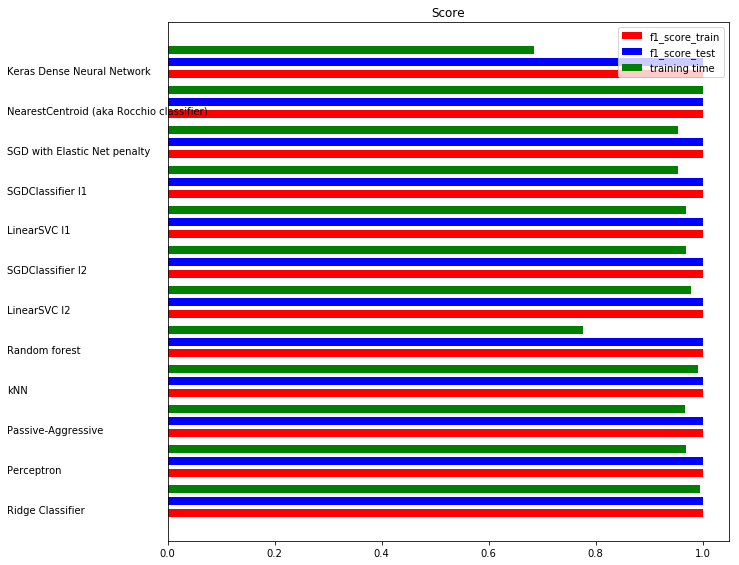

In [134]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, f1_score_train, f1_score_test, training_time = results

training_time = np.array(training_time) / np.max(training_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, f1_score_train, .2, label="f1_score_train", color='r')
plt.barh(indices+0.3, f1_score_test, .2, label="f1_score_test", color='b')
plt.barh(indices + .6, training_time, .2, label="training time", color='g')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, model_name):
    plt.text(-.3, i, c)

plt.show()

# Store the best model and accuracy for a sample Size in array

In [115]:
#Sample Size 100
index100=np.argmax(f1_score_test)
print(index100)
f1score100 = f1_score_test[index100]
print(f1score100)
print(model_name[index100])

3
1.0
kNN


In [86]:
#Sample Size 500
index500=np.argmax(f1_score_test)
f1score500 = f1_score_test[index500]
print(f1score500)
print(model_name[index500])

1.0
Ridge Classifier


In [94]:
#Sample Size 1000
index1000=np.argmax(f1_score_test)
f1score1000 = f1_score_test[index1000]
print(f1score1000)
print(model_name[index1000])

1.0
kNN


In [101]:
#Sample Size 2000
index2000=np.argmax(f1_score_test)
f1score2000 = f1_score_test[index2000]
print(f1score2000)
print(model_name[index2000])

0.664440734557596
kNN


# Plot the accuracy scores (F1-scores) of the best model vs sample Size

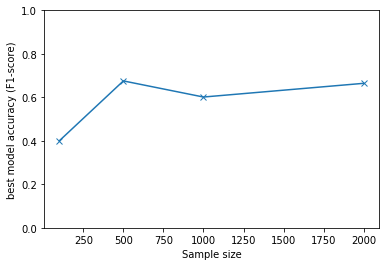

In [103]:
##Plotting the best model f1-scores

import matplotlib.pyplot as plt
plt.plot([100, 500, 1000, 2000],[f1score100,f1score500,f1score1000,f1score2000],marker="x")
plt.ylim(0,1)
plt.ylabel('best model accuracy (F1-score)')
plt.xlabel('Sample size')
plt.show()

# Print the best Model names at various sample Sizes

In [104]:
print("Best classifier is:"+model_name[index100],"||f1_score",f1score100)
print("Best classifier is:"+model_name[index500],"||f1_score",f1score500)
print("Best classifier is:"+model_name[index1000],"||f1_score",f1score1000)
print("Best classifier is:"+model_name[index2000],"||f1_score",f1score2000)

Best classifier is:Ridge Classifier ||f1_score 0.4
Best classifier is:Ridge Classifier ||f1_score 0.6754966887417219
Best classifier is:Ridge Classifier ||f1_score 0.6013986013986015
Best classifier is:kNN ||f1_score 0.664440734557596
